In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics
!pip install --upgrade pytorch-pretrained-vit
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=e701aa8961c34970fe78c3e0633db2817df4eefb60043fa3b619247946df9f6b
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=69f286356fe602f41027ca7efb3fc539145d465bbe274ff4f9d99adbf2f09425
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [1]:
# from sklearn.manifold import TSNE
# from sklearn.metrics import f1_score, precision_score, recall_score
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sn
# import numpy as np
import random
import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# from torchvision.utils import make_grid
# from torch.utils.data import Dataset, DataLoader
# import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# import math
# import scipy.io as sio
from efficientnet_pytorch import EfficientNet

In [2]:
from resViT.model import *
from resViT.train import *
from resViT.loaddata import *

In [3]:
tarData = ['FE_tar_7_1', 'FE_tar_7_2', 'FE_tar_7_3', 'FE_tar_14_1', 'FE_tar_14_2',
           'FE_tar_14_3', 'FE_tar_21_1', 'FE_tar_21_2', 'FE_tar_21_3', 'ims_tar'];

root_path = './cwruData/' #running from local
img_size=128

# Proposed ViT training with Knowledge transfer method

In [4]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = torch.load('./saved_models/ViT_src_7_0.pth', map_location=device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss() #Define classification loss
    print(f'Fine tuning model for traget data: {tarData[tar]}')
    Model = train_pr(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ViT_'+tarData[tar]+'_N.pth')

Fine tuning model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 71.00    Val Accuracy = 63.82
[1/20]   Train Accuracy = 88.49    Val Accuracy = 70.07
[2/20]   Train Accuracy = 94.52    Val Accuracy = 78.70
[3/20]   Train Accuracy = 94.35    Val Accuracy = 86.76
[4/20]   Train Accuracy = 98.65    Val Accuracy = 98.95
[5/20]   Train Accuracy = 97.70    Val Accuracy = 96.37
[6/20]   Train Accuracy = 95.42    Val Accuracy = 95.09
[7/20]   Train Accuracy = 98.85    Val Accuracy = 97.52
[8/20]   Train Accuracy = 96.65    Val Accuracy = 98.13
[9/20]   Train Accuracy = 98.34    Val Accuracy = 95.73
[10/20]   Train Accuracy = 99.35    Val Accuracy = 95.36
[11/20]   Train Accuracy = 99.13    Val Accuracy = 96.88
[12/20]   Train Accuracy = 98.03    Val Accuracy = 94.96
[13/20]   Train Accuracy = 97.18    Val Accuracy = 96.15
[14/20]   Train Accuracy = 98.03    Val Accuracy = 95.36
[15/20]   Train Accuracy = 98.70    Val Accuracy = 98.47
[16/20]   Train Accuracy =

Validation Accuracy =  99.0625
__________________________________________________
Pricision Score = 0.9912317620650954
__________________________________________________
F_1 Score =  0.9908754600664974
__________________________________________________
Recall Score =  0.9906635802469136
__________________________________________________
Response time per batch 0.8535730838775635


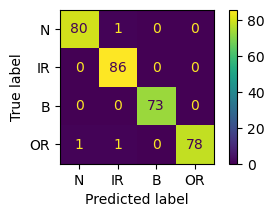

In [4]:
# Validate and Visualize
Model = torch.load('./saved_models/ViT_'+tarData[0]+'_N.pth', map_location=device)
TrainLoader, TestLoader, ValLoader,_ = loadNoisydata(root_path, tarData[0])
val_acc, cm, prec, f1, recall, time_batch,_,_ = validate_pr(Model, TestLoader, 4)
print('Validation Accuracy = ', 100*val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvit = {'Modelname':['ViT_attn'+tarData[0]], 'Val Acc.': 100*val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [ ]:
perfvit = pd.DataFrame(perfvit)
# perfData.to_csv('results_'+ tarData[tar]+ '.csv')
perfvit

,Modelname,Val Acc.,Precision,F1_score,Recall
0,ViT_attnFE_tar_21_3,100.0,1.0,1.0,1.0


# Train benchmark models for comparisions
## Models: Standard ViT, EfficientNet, ResNeXt, DenseNet, VGGNet, GoogleNet, SqeezeNet

### Standard ViT wth 12 encoder block pre-trained in ImageNet1k

In [7]:
for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = ViTpretrain(img_size, numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning pre-trained ViT model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ViT_pre_'+tarData[tar]+'_N.pth')

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.
Fine tuning pre-trained ViT model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 40.33    Val Accuracy = 59.38
[1/20]   Train Accuracy = 81.74    Val Accuracy = 79.30
[2/20]   Train Accuracy = 93.07    Val Accuracy = 89.06
[3/20]   Train Accuracy = 94.34    Val Accuracy = 89.84
[4/20]   Train Accuracy = 95.61    Val Accuracy = 93.36
[5/20]   Train Accuracy = 95.80    Val Accuracy = 92.19
[6/20]   Train Accuracy = 97.36    Val Accuracy = 89.06
[7/20]   Train Accuracy = 97.07    Val Accuracy = 91.41
[8/20]   Train Accuracy = 98.63    Val Accuracy = 92.19
[9/20]   Train Accuracy = 99.12    Val Accuracy = 89.84
[10/20]   Train Accuracy = 99.12    Val Accuracy = 92.19
[11/20]   Train Accuracy = 99.32    Val Accuracy = 93.36
[12/20]   Train Accuracy = 99.71    Val Accuracy = 90.23
[13/20]   Train Accuracy = 99.51    Val Accuracy = 90.23
[14/20] 

Validation Accuracy =  95.9375
__________________________________________________
Pricision Score = 0.960227870058873
__________________________________________________
F_1 Score =  0.9568649134235325
__________________________________________________
Recall Score =  0.9561559276171148
__________________________________________________
Response time per batch
 0.011023283004760742
Validation Accuracy =  91.5625
__________________________________________________
Pricision Score = 0.9258536139503092
__________________________________________________
F_1 Score =  0.9163551983564097
__________________________________________________
Recall Score =  0.9152601229744293
__________________________________________________
Response time per batch
 0.009892702102661133
Validation Accuracy =  91.25
__________________________________________________
Pricision Score = 0.9110440719181399
__________________________________________________
F_1 Score =  0.9076366453039381
_______________________________

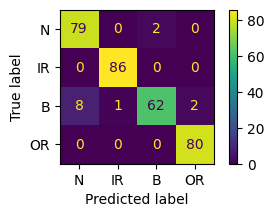

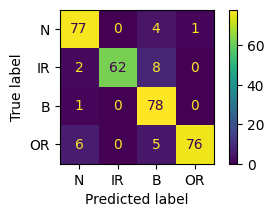

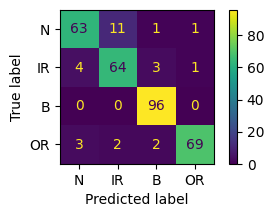

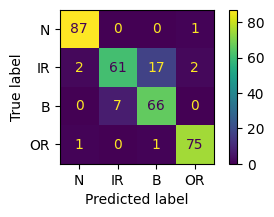

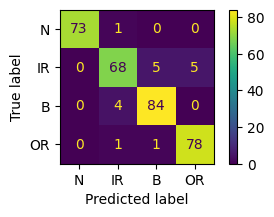

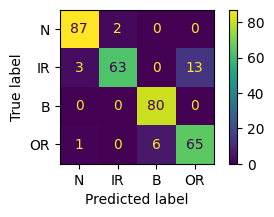

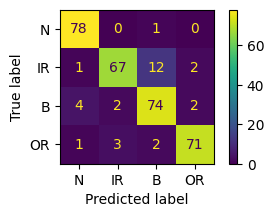

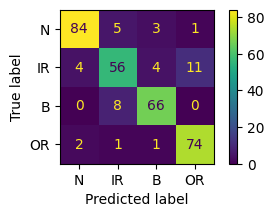

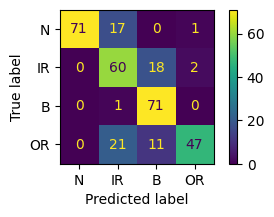

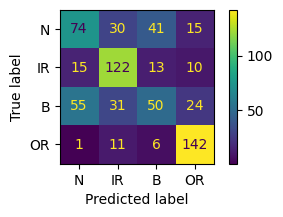

In [9]:
# Validate and Visualize
perfvit_pre = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
for name in tarData:
    Model = torch.load('./saved_models/ViT_pre_'+ name +'_N.pth', map_location=device)
    _, TestLoader, _, numClass = loadNoisydata(root_path, name)
    val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
    print('Validation Accuracy = ', val_acc)
    print("__________________________________________________")
    print(f'Pricision Score = {prec}')
    print('__________________________________________________')
    print(f'F_1 Score =  {f1}')
    print('__________________________________________________')
    print(f"Recall Score =  {recall}")
    print('__________________________________________________')
    print('Response time per batch\n', time_batch)
    disp_conf_matrix(cm)

    perfvit_pre = pd.concat((perfvit_pre, pd.DataFrame({name : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### EfficientNet

In [10]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = EfficientNet.from_pretrained('efficientnet-b1')
    Model._fc = EffNetFC(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning EfficentNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/efficient_'+tarData[tar]+'_N.pth')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 180MB/s]


Loaded pretrained weights for efficientnet-b1
Fine tuning EfficentNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 29.98    Val Accuracy = 30.86
[1/20]   Train Accuracy = 32.81    Val Accuracy = 40.23
[2/20]   Train Accuracy = 40.62    Val Accuracy = 53.12
[3/20]   Train Accuracy = 51.27    Val Accuracy = 57.81
[4/20]   Train Accuracy = 66.41    Val Accuracy = 79.30
[5/20]   Train Accuracy = 91.41    Val Accuracy = 81.64
[6/20]   Train Accuracy = 97.66    Val Accuracy = 84.77
[7/20]   Train Accuracy = 98.83    Val Accuracy = 85.94
[8/20]   Train Accuracy = 99.90    Val Accuracy = 86.33
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.72
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[11/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[12/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[13/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[14/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[15/20]   Train Accu

Validation Accuracy =  91.875
__________________________________________________
Pricision Score = 0.9196830119776177
__________________________________________________
F_1 Score =  0.9140569730825641
__________________________________________________
Recall Score =  0.9135490656181295
__________________________________________________
Response time per batch 0.0627131462097168


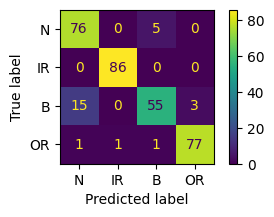

In [13]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, _ = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/efficient_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch,_, _ = validate(Model, TestLoader, 4)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfEffNet = {'Modelname':['EfficientNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### ResNeXt

In [14]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader,numClass = loadNoisydata(root_path, tarData[tar])
    Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
    Model.fc = ResNetFC(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning ResNeXt model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ResNeXt_'+tarData[tar]+'_N.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 139MB/s]


Fine tuning ResNeXt model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 67.58    Val Accuracy = 89.45
[1/20]   Train Accuracy = 98.05    Val Accuracy = 88.28
[2/20]   Train Accuracy = 99.61    Val Accuracy = 88.28
[3/20]   Train Accuracy = 99.80    Val Accuracy = 92.58
[4/20]   Train Accuracy = 99.90    Val Accuracy = 91.41
[5/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[6/20]   Train Accuracy = 99.90    Val Accuracy = 92.58
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[9/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[10/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 65.92    Val Accuracy = 89.06
[1/20]   Train Accuracy = 98.83    Val Accuracy = 85.16
[2/20]   Train Accuracy = 99.61    Val Accuracy = 89.06
[3/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[4/20]   Train Accuracy = 99.90    Val Accuracy = 88.67
[5/20]   Train Accuracy = 99.90    Val Accuracy = 89.84
[6/20]   Train Accuracy = 99.80    Val Accuracy = 89.84
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[8/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[10/20]   Train Accuracy = 99.90    Val Accuracy = 92.58
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[15/20]   Train Accuracy = 99.90    Val Accuracy = 93.36
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 67.58    Val Accuracy = 85.55
[1/20]   Train Accuracy = 98.73    Val Accuracy = 92.58
[2/20]   Train Accuracy = 99.80    Val Accuracy = 89.84
[3/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[4/20]   Train Accuracy = 99.90    Val Accuracy = 92.97
[5/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[6/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[7/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[10/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[11/20]   Train Accuracy = 99.80    Val Accuracy = 92.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[13/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 63.67    Val Accuracy = 82.81
[1/20]   Train Accuracy = 97.66    Val Accuracy = 87.50
[2/20]   Train Accuracy = 99.51    Val Accuracy = 86.72
[3/20]   Train Accuracy = 99.22    Val Accuracy = 88.67
[4/20]   Train Accuracy = 99.71    Val Accuracy = 88.28
[5/20]   Train Accuracy = 100.00    Val Accuracy = 85.55
[6/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[7/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[11/20]   Train Accuracy = 99.90    Val Accuracy = 84.38
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 62.50    Val Accuracy = 90.62
[1/20]   Train Accuracy = 97.85    Val Accuracy = 94.14
[2/20]   Train Accuracy = 99.80    Val Accuracy = 92.97
[3/20]   Train Accuracy = 99.51    Val Accuracy = 92.97
[4/20]   Train Accuracy = 99.71    Val Accuracy = 93.75
[5/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[6/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[11/20]   Train Accuracy = 99.80    Val Accuracy = 94.53
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[13/20]   Train Accuracy = 99.80    Val Accuracy = 93.36
[14/20]   Train Accuracy = 99.61    Val Accuracy = 96.09
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 72.46    Val Accuracy = 85.94
[1/20]   Train Accuracy = 98.34    Val Accuracy = 87.89
[2/20]   Train Accuracy = 99.80    Val Accuracy = 88.28
[3/20]   Train Accuracy = 99.32    Val Accuracy = 89.84
[4/20]   Train Accuracy = 99.90    Val Accuracy = 86.72
[5/20]   Train Accuracy = 99.80    Val Accuracy = 88.67
[6/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[7/20]   Train Accuracy = 99.80    Val Accuracy = 91.41
[8/20]   Train Accuracy = 99.90    Val Accuracy = 91.41
[9/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 64.55    Val Accuracy = 85.94
[1/20]   Train Accuracy = 98.73    Val Accuracy = 86.33
[2/20]   Train Accuracy = 99.61    Val Accuracy = 88.28
[3/20]   Train Accuracy = 99.51    Val Accuracy = 86.72
[4/20]   Train Accuracy = 99.71    Val Accuracy = 89.45
[5/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[7/20]   Train Accuracy = 99.90    Val Accuracy = 89.06
[8/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[11/20]   Train Accuracy = 99.71    Val Accuracy = 93.36
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[15/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 52.64    Val Accuracy = 78.91
[1/20]   Train Accuracy = 97.95    Val Accuracy = 78.52
[2/20]   Train Accuracy = 99.32    Val Accuracy = 80.08
[3/20]   Train Accuracy = 99.71    Val Accuracy = 80.47
[4/20]   Train Accuracy = 99.90    Val Accuracy = 82.42
[5/20]   Train Accuracy = 99.80    Val Accuracy = 80.86
[6/20]   Train Accuracy = 99.90    Val Accuracy = 83.20
[7/20]   Train Accuracy = 100.00    Val Accuracy = 80.08
[8/20]   Train Accuracy = 100.00    Val Accuracy = 85.94
[9/20]   Train Accuracy = 99.90    Val Accuracy = 85.55
[10/20]   Train Accuracy = 100.00    Val Accuracy = 82.81
[11/20]   Train Accuracy = 100.00    Val Accuracy = 81.64
[12/20]   Train Accuracy = 99.90    Val Accuracy = 84.77
[13/20]   Train Accuracy = 99.90    Val Accuracy = 80.86
[14/20]   Train Accuracy = 99.71    Val Accuracy = 82.42
[15/20]   Train Accuracy = 100.00    Val Accuracy = 85.94
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 61.04    Val Accuracy = 70.70
[1/20]   Train Accuracy = 99.02    Val Accuracy = 69.92
[2/20]   Train Accuracy = 99.90    Val Accuracy = 74.22
[3/20]   Train Accuracy = 99.51    Val Accuracy = 76.95
[4/20]   Train Accuracy = 99.80    Val Accuracy = 78.12
[5/20]   Train Accuracy = 99.61    Val Accuracy = 76.17
[6/20]   Train Accuracy = 99.71    Val Accuracy = 79.30
[7/20]   Train Accuracy = 99.80    Val Accuracy = 80.47
[8/20]   Train Accuracy = 99.61    Val Accuracy = 80.47
[9/20]   Train Accuracy = 99.80    Val Accuracy = 81.25
[10/20]   Train Accuracy = 99.90    Val Accuracy = 79.30
[11/20]   Train Accuracy = 99.90    Val Accuracy = 83.20
[12/20]   Train Accuracy = 100.00    Val Accuracy = 82.42
[13/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[14/20]   Train Accuracy = 100.00    Val Accuracy = 80.86
[15/20]   Train Accuracy = 100.00    Val Accuracy = 80.86
[16/20]   Tra

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 57.67    Val Accuracy = 51.76
[1/20]   Train Accuracy = 82.52    Val Accuracy = 53.91
[2/20]   Train Accuracy = 93.02    Val Accuracy = 54.49
[3/20]   Train Accuracy = 96.29    Val Accuracy = 53.71
[4/20]   Train Accuracy = 98.54    Val Accuracy = 53.52
[5/20]   Train Accuracy = 99.66    Val Accuracy = 55.08
[6/20]   Train Accuracy = 99.66    Val Accuracy = 56.05
[7/20]   Train Accuracy = 99.71    Val Accuracy = 55.27
[8/20]   Train Accuracy = 99.90    Val Accuracy = 55.86
[9/20]   Train Accuracy = 99.80    Val Accuracy = 53.12
[10/20]   Train Accuracy = 100.00    Val Accuracy = 54.69
[11/20]   Train Accuracy = 99.95    Val Accuracy = 56.64
[12/20]   Train Accuracy = 99.90    Val Accuracy = 55.86
[13/20]   Train Accuracy = 99.90    Val Accuracy = 58.98
[14/20]   Train Accuracy = 99.95    Val Accuracy = 54.30
[15/20]   Train Accuracy = 99.95    Val Accuracy = 55.66
[16/20]   Train Accu

Validation Accuracy =  92.5
__________________________________________________
Pricision Score = 0.9269400352733685
__________________________________________________
F_1 Score =  0.9232334363655037
__________________________________________________
Recall Score =  0.9244778822971852
__________________________________________________
Response time per batch 0.016263961791992188


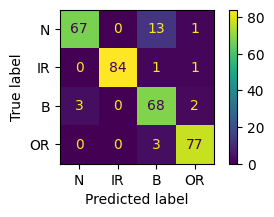

In [15]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/ResNeXt_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfResNeXt = {'Modelname':['ResNeXt_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### DenseNet

In [16]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = DenseNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning DenseNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/DenseNet_'+tarData[tar]+'_N.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]


Fine tuning DenseNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 60.06    Val Accuracy = 82.03
[1/20]   Train Accuracy = 97.46    Val Accuracy = 89.45
[2/20]   Train Accuracy = 99.32    Val Accuracy = 89.06
[3/20]   Train Accuracy = 99.90    Val Accuracy = 90.23
[4/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[5/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[8/20]   Train Accuracy = 99.80    Val Accuracy = 87.50
[9/20]   Train Accuracy = 99.90    Val Accuracy = 92.19
[10/20]   Train Accuracy = 99.90    Val Accuracy = 91.02
[11/20]   Train Accuracy = 100.00    Val Accuracy = 88.28
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.67
[14/20]   Train Accuracy = 99.80    Val Accuracy = 94.14
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 58.11    Val Accuracy = 85.94
[1/20]   Train Accuracy = 97.66    Val Accuracy = 87.89
[2/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[3/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[4/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[5/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[6/20]   Train Accuracy = 99.80    Val Accuracy = 85.55
[7/20]   Train Accuracy = 99.80    Val Accuracy = 89.06
[8/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[9/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[10/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[11/20]   Train Accuracy = 99.90    Val Accuracy = 86.72
[12/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[13/20]   Train Accuracy = 99.90    Val Accuracy = 92.58
[14/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[15/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 60.06    Val Accuracy = 86.72
[1/20]   Train Accuracy = 98.14    Val Accuracy = 91.41
[2/20]   Train Accuracy = 99.80    Val Accuracy = 93.75
[3/20]   Train Accuracy = 99.90    Val Accuracy = 86.33
[4/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[5/20]   Train Accuracy = 99.90    Val Accuracy = 94.53
[6/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[7/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[8/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 59.38    Val Accuracy = 85.16
[1/20]   Train Accuracy = 95.51    Val Accuracy = 87.89
[2/20]   Train Accuracy = 99.41    Val Accuracy = 87.89
[3/20]   Train Accuracy = 100.00    Val Accuracy = 88.67
[4/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[5/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[6/20]   Train Accuracy = 99.90    Val Accuracy = 89.45
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[8/20]   Train Accuracy = 99.90    Val Accuracy = 88.67
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[14/20]   Train Accuracy = 99.71    Val Accuracy = 91.02
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 54.88    Val Accuracy = 81.64
[1/20]   Train Accuracy = 94.43    Val Accuracy = 86.33
[2/20]   Train Accuracy = 99.22    Val Accuracy = 93.75
[3/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[4/20]   Train Accuracy = 99.90    Val Accuracy = 94.14
[5/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[7/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[10/20]   Train Accuracy = 99.90    Val Accuracy = 93.36
[11/20]   Train Accuracy = 99.80    Val Accuracy = 82.81
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[13/20]   Train Accuracy = 99.80    Val Accuracy = 93.36
[14/20]   Train Accuracy = 99.71    Val Accuracy = 95.31
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 63.57    Val Accuracy = 88.67
[1/20]   Train Accuracy = 99.02    Val Accuracy = 89.45
[2/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[3/20]   Train Accuracy = 99.90    Val Accuracy = 89.45
[4/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[5/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[8/20]   Train Accuracy = 99.71    Val Accuracy = 92.19
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[11/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[15/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[16/

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 54.00    Val Accuracy = 83.59
[1/20]   Train Accuracy = 95.02    Val Accuracy = 85.16
[2/20]   Train Accuracy = 98.73    Val Accuracy = 84.77
[3/20]   Train Accuracy = 99.71    Val Accuracy = 90.23
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[5/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[6/20]   Train Accuracy = 99.80    Val Accuracy = 90.62
[7/20]   Train Accuracy = 99.90    Val Accuracy = 88.28
[8/20]   Train Accuracy = 99.71    Val Accuracy = 91.80
[9/20]   Train Accuracy = 99.41    Val Accuracy = 87.89
[10/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[11/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[14/20]   Train Accuracy = 99.90    Val Accuracy = 91.41
[15/20]   Train Accuracy = 99.90    Val Accuracy = 90.23
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 56.54    Val Accuracy = 74.22
[1/20]   Train Accuracy = 92.68    Val Accuracy = 81.25
[2/20]   Train Accuracy = 99.32    Val Accuracy = 80.47
[3/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[4/20]   Train Accuracy = 100.00    Val Accuracy = 84.77
[5/20]   Train Accuracy = 100.00    Val Accuracy = 79.69
[6/20]   Train Accuracy = 99.71    Val Accuracy = 82.03
[7/20]   Train Accuracy = 99.61    Val Accuracy = 82.03
[8/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[9/20]   Train Accuracy = 99.80    Val Accuracy = 84.77
[10/20]   Train Accuracy = 100.00    Val Accuracy = 83.98
[11/20]   Train Accuracy = 100.00    Val Accuracy = 82.42
[12/20]   Train Accuracy = 100.00    Val Accuracy = 83.59
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[14/20]   Train Accuracy = 100.00    Val Accuracy = 85.16
[15/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 48.34    Val Accuracy = 69.53
[1/20]   Train Accuracy = 93.75    Val Accuracy = 74.61
[2/20]   Train Accuracy = 98.83    Val Accuracy = 73.83
[3/20]   Train Accuracy = 100.00    Val Accuracy = 72.66
[4/20]   Train Accuracy = 100.00    Val Accuracy = 78.52
[5/20]   Train Accuracy = 100.00    Val Accuracy = 74.61
[6/20]   Train Accuracy = 99.90    Val Accuracy = 73.44
[7/20]   Train Accuracy = 99.12    Val Accuracy = 73.44
[8/20]   Train Accuracy = 99.61    Val Accuracy = 71.09
[9/20]   Train Accuracy = 100.00    Val Accuracy = 76.17
[10/20]   Train Accuracy = 99.90    Val Accuracy = 73.83
[11/20]   Train Accuracy = 100.00    Val Accuracy = 77.34
[12/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[13/20]   Train Accuracy = 99.90    Val Accuracy = 76.17
[14/20]   Train Accuracy = 100.00    Val Accuracy = 76.95
[15/20]   Train Accuracy = 99.80    Val Accuracy = 75.00
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 49.51    Val Accuracy = 52.34
[1/20]   Train Accuracy = 74.71    Val Accuracy = 56.25
[2/20]   Train Accuracy = 90.53    Val Accuracy = 58.59
[3/20]   Train Accuracy = 97.17    Val Accuracy = 55.27
[4/20]   Train Accuracy = 98.39    Val Accuracy = 57.62
[5/20]   Train Accuracy = 98.93    Val Accuracy = 52.93
[6/20]   Train Accuracy = 99.71    Val Accuracy = 54.88
[7/20]   Train Accuracy = 99.71    Val Accuracy = 55.08
[8/20]   Train Accuracy = 99.80    Val Accuracy = 55.86
[9/20]   Train Accuracy = 99.85    Val Accuracy = 57.42
[10/20]   Train Accuracy = 99.22    Val Accuracy = 55.86
[11/20]   Train Accuracy = 99.80    Val Accuracy = 54.49
[12/20]   Train Accuracy = 99.66    Val Accuracy = 57.81
[13/20]   Train Accuracy = 99.95    Val Accuracy = 54.10
[14/20]   Train Accuracy = 100.00    Val Accuracy = 51.56
[15/20]   Train Accuracy = 100.00    Val Accuracy = 54.88
[16/20]   Train Ac

Validation Accuracy =  95.0
__________________________________________________
Pricision Score = 0.9491007007256773
__________________________________________________
F_1 Score =  0.9480914359823533
__________________________________________________
Recall Score =  0.9478548694441494
__________________________________________________
Response time per batch 0.02352738380432129


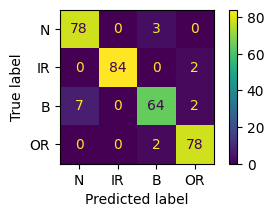

In [17]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/DenseNet_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfDenseNet = {'Modelname':['DenseNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### vgg16Net

In [18]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = vgg16Net(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning vgg16Net model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/vgg16Net_'+tarData[tar]+'_N.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]


Fine tuning vgg16Net model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 76.27    Val Accuracy = 82.42
[1/20]   Train Accuracy = 90.53    Val Accuracy = 91.02
[2/20]   Train Accuracy = 93.75    Val Accuracy = 92.58
[3/20]   Train Accuracy = 96.68    Val Accuracy = 92.58
[4/20]   Train Accuracy = 97.95    Val Accuracy = 91.02
[5/20]   Train Accuracy = 99.61    Val Accuracy = 88.28
[6/20]   Train Accuracy = 98.63    Val Accuracy = 88.28
[7/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[8/20]   Train Accuracy = 99.41    Val Accuracy = 91.80
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[15/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 72.56    Val Accuracy = 83.20
[1/20]   Train Accuracy = 92.87    Val Accuracy = 85.16
[2/20]   Train Accuracy = 96.19    Val Accuracy = 91.02
[3/20]   Train Accuracy = 98.63    Val Accuracy = 91.41
[4/20]   Train Accuracy = 99.61    Val Accuracy = 87.89
[5/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[7/20]   Train Accuracy = 99.02    Val Accuracy = 91.41
[8/20]   Train Accuracy = 99.61    Val Accuracy = 92.97
[9/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[10/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 71.00    Val Accuracy = 83.98
[1/20]   Train Accuracy = 92.48    Val Accuracy = 88.67
[2/20]   Train Accuracy = 95.70    Val Accuracy = 92.58
[3/20]   Train Accuracy = 98.14    Val Accuracy = 90.62
[4/20]   Train Accuracy = 99.02    Val Accuracy = 91.80
[5/20]   Train Accuracy = 99.51    Val Accuracy = 89.84
[6/20]   Train Accuracy = 99.71    Val Accuracy = 95.70
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[8/20]   Train Accuracy = 99.80    Val Accuracy = 92.97
[9/20]   Train Accuracy = 99.51    Val Accuracy = 93.75
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[15/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 66.21    Val Accuracy = 83.98
[1/20]   Train Accuracy = 88.28    Val Accuracy = 89.06
[2/20]   Train Accuracy = 91.99    Val Accuracy = 83.59
[3/20]   Train Accuracy = 95.21    Val Accuracy = 92.58
[4/20]   Train Accuracy = 97.36    Val Accuracy = 94.92
[5/20]   Train Accuracy = 99.02    Val Accuracy = 91.41
[6/20]   Train Accuracy = 99.32    Val Accuracy = 92.97
[7/20]   Train Accuracy = 100.00    Val Accuracy = 88.28
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[13/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 71.97    Val Accuracy = 80.08
[1/20]   Train Accuracy = 92.58    Val Accuracy = 94.14
[2/20]   Train Accuracy = 95.80    Val Accuracy = 92.97
[3/20]   Train Accuracy = 98.93    Val Accuracy = 96.48
[4/20]   Train Accuracy = 99.32    Val Accuracy = 94.92
[5/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[6/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[10/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[11/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[13/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 70.80    Val Accuracy = 77.73
[1/20]   Train Accuracy = 91.60    Val Accuracy = 91.80
[2/20]   Train Accuracy = 93.85    Val Accuracy = 85.55
[3/20]   Train Accuracy = 95.21    Val Accuracy = 89.84
[4/20]   Train Accuracy = 96.58    Val Accuracy = 89.84
[5/20]   Train Accuracy = 99.32    Val Accuracy = 89.45
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[7/20]   Train Accuracy = 99.41    Val Accuracy = 91.80
[8/20]   Train Accuracy = 99.90    Val Accuracy = 91.02
[9/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[11/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 32.71    Val Accuracy = 60.16
[1/20]   Train Accuracy = 76.76    Val Accuracy = 87.89
[2/20]   Train Accuracy = 88.67    Val Accuracy = 89.45
[3/20]   Train Accuracy = 90.62    Val Accuracy = 90.23
[4/20]   Train Accuracy = 94.82    Val Accuracy = 89.45
[5/20]   Train Accuracy = 97.17    Val Accuracy = 92.97
[6/20]   Train Accuracy = 97.75    Val Accuracy = 89.84
[7/20]   Train Accuracy = 98.93    Val Accuracy = 91.80
[8/20]   Train Accuracy = 98.24    Val Accuracy = 92.19
[9/20]   Train Accuracy = 99.71    Val Accuracy = 91.80
[10/20]   Train Accuracy = 99.71    Val Accuracy = 92.58
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 37.89    Val Accuracy = 50.00
[1/20]   Train Accuracy = 71.68    Val Accuracy = 79.30
[2/20]   Train Accuracy = 83.20    Val Accuracy = 83.20
[3/20]   Train Accuracy = 87.99    Val Accuracy = 80.47
[4/20]   Train Accuracy = 90.92    Val Accuracy = 81.25
[5/20]   Train Accuracy = 94.53    Val Accuracy = 75.39
[6/20]   Train Accuracy = 95.70    Val Accuracy = 83.98
[7/20]   Train Accuracy = 99.51    Val Accuracy = 82.42
[8/20]   Train Accuracy = 96.97    Val Accuracy = 85.55
[9/20]   Train Accuracy = 99.32    Val Accuracy = 78.12
[10/20]   Train Accuracy = 99.90    Val Accuracy = 82.81
[11/20]   Train Accuracy = 99.41    Val Accuracy = 84.77
[12/20]   Train Accuracy = 99.71    Val Accuracy = 80.86
[13/20]   Train Accuracy = 99.80    Val Accuracy = 83.59
[14/20]   Train Accuracy = 100.00    Val Accuracy = 85.55
[15/20]   Train Accuracy = 100.00    Val Accuracy = 83.59
[16/20]   Trai

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 50.98    Val Accuracy = 51.95
[1/20]   Train Accuracy = 77.05    Val Accuracy = 76.56
[2/20]   Train Accuracy = 83.01    Val Accuracy = 76.17
[3/20]   Train Accuracy = 87.79    Val Accuracy = 71.48
[4/20]   Train Accuracy = 91.70    Val Accuracy = 77.34
[5/20]   Train Accuracy = 95.90    Val Accuracy = 80.86
[6/20]   Train Accuracy = 98.73    Val Accuracy = 72.27
[7/20]   Train Accuracy = 99.02    Val Accuracy = 82.03
[8/20]   Train Accuracy = 99.32    Val Accuracy = 69.92
[9/20]   Train Accuracy = 99.61    Val Accuracy = 82.03
[10/20]   Train Accuracy = 100.00    Val Accuracy = 78.91
[11/20]   Train Accuracy = 100.00    Val Accuracy = 80.08
[12/20]   Train Accuracy = 99.80    Val Accuracy = 80.47
[13/20]   Train Accuracy = 100.00    Val Accuracy = 83.98
[14/20]   Train Accuracy = 100.00    Val Accuracy = 82.03
[15/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 40.14    Val Accuracy = 49.02
[1/20]   Train Accuracy = 57.13    Val Accuracy = 57.03
[2/20]   Train Accuracy = 61.82    Val Accuracy = 51.95
[3/20]   Train Accuracy = 64.70    Val Accuracy = 58.40
[4/20]   Train Accuracy = 67.19    Val Accuracy = 57.03
[5/20]   Train Accuracy = 74.12    Val Accuracy = 54.88
[6/20]   Train Accuracy = 77.78    Val Accuracy = 57.62
[7/20]   Train Accuracy = 82.03    Val Accuracy = 56.25
[8/20]   Train Accuracy = 85.60    Val Accuracy = 55.86
[9/20]   Train Accuracy = 90.38    Val Accuracy = 57.23
[10/20]   Train Accuracy = 93.36    Val Accuracy = 54.69
[11/20]   Train Accuracy = 97.66    Val Accuracy = 56.64
[12/20]   Train Accuracy = 99.07    Val Accuracy = 58.01
[13/20]   Train Accuracy = 99.41    Val Accuracy = 58.59
[14/20]   Train Accuracy = 99.95    Val Accuracy = 55.08
[15/20]   Train Accuracy = 100.00    Val Accuracy = 56.84
[16/20]   Train Acc

Validation Accuracy =  95.0
__________________________________________________
Pricision Score = 0.9481390950094573
__________________________________________________
F_1 Score =  0.948041251047645
__________________________________________________
Recall Score =  0.9481338787417555
__________________________________________________
Response time per batch 0.001953125


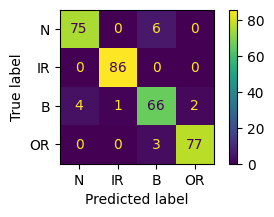

In [19]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/vgg16Net_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvgg16Net = {'Modelname':['vgg16Net_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### GoogleNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = googleNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning GoogleNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/GoogleNet_'+tarData[tar]+'_N.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 70.9MB/s]


Fine tuning GoogleNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 50.98    Val Accuracy = 72.27
[1/20]   Train Accuracy = 92.87    Val Accuracy = 81.64
[2/20]   Train Accuracy = 99.51    Val Accuracy = 80.86
[3/20]   Train Accuracy = 99.90    Val Accuracy = 83.59
[4/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[5/20]   Train Accuracy = 100.00    Val Accuracy = 83.59
[6/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[7/20]   Train Accuracy = 99.90    Val Accuracy = 82.42
[8/20]   Train Accuracy = 100.00    Val Accuracy = 84.77
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[11/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[12/20]   Train Accuracy = 100.00    Val Accuracy = 88.28
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[14/20]   Train Accuracy = 99.90    Val Accuracy = 85.16
[15/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 50.10    Val Accuracy = 76.56
[1/20]   Train Accuracy = 94.92    Val Accuracy = 83.59
[2/20]   Train Accuracy = 99.61    Val Accuracy = 87.89
[3/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[4/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[5/20]   Train Accuracy = 100.00    Val Accuracy = 86.72
[6/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[7/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[8/20]   Train Accuracy = 99.71    Val Accuracy = 85.94
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.72
[10/20]   Train Accuracy = 100.00    Val Accuracy = 86.72
[11/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[12/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[14/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[16/

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 52.64    Val Accuracy = 77.73
[1/20]   Train Accuracy = 97.07    Val Accuracy = 85.16
[2/20]   Train Accuracy = 99.41    Val Accuracy = 91.02
[3/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[4/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[5/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[6/20]   Train Accuracy = 100.00    Val Accuracy = 86.33
[7/20]   Train Accuracy = 99.90    Val Accuracy = 88.67
[8/20]   Train Accuracy = 99.90    Val Accuracy = 89.45
[9/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[10/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[14/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[15/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[16/2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 55.76    Val Accuracy = 80.08
[1/20]   Train Accuracy = 91.50    Val Accuracy = 85.94
[2/20]   Train Accuracy = 96.00    Val Accuracy = 85.16
[3/20]   Train Accuracy = 99.90    Val Accuracy = 84.77
[4/20]   Train Accuracy = 100.00    Val Accuracy = 83.98
[5/20]   Train Accuracy = 99.90    Val Accuracy = 89.06
[6/20]   Train Accuracy = 99.90    Val Accuracy = 87.11
[7/20]   Train Accuracy = 99.61    Val Accuracy = 89.06
[8/20]   Train Accuracy = 99.80    Val Accuracy = 88.28
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[10/20]   Train Accuracy = 98.34    Val Accuracy = 89.06
[11/20]   Train Accuracy = 100.00    Val Accuracy = 85.16
[12/20]   Train Accuracy = 99.90    Val Accuracy = 89.45
[13/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[14/20]   Train Accuracy = 99.61    Val Accuracy = 90.23
[15/20]   Train Accuracy = 100.00    Val Accuracy = 88.67
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 53.71    Val Accuracy = 74.61
[1/20]   Train Accuracy = 94.34    Val Accuracy = 87.89
[2/20]   Train Accuracy = 99.71    Val Accuracy = 90.23
[3/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[5/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[7/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[8/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[10/20]   Train Accuracy = 99.80    Val Accuracy = 88.67
[11/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[12/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[13/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[16/

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 60.94    Val Accuracy = 76.56
[1/20]   Train Accuracy = 93.75    Val Accuracy = 88.67
[2/20]   Train Accuracy = 99.41    Val Accuracy = 88.67
[3/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[5/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[8/20]   Train Accuracy = 100.00    Val Accuracy = 91.80
[9/20]   Train Accuracy = 100.00    Val Accuracy = 88.28
[10/20]   Train Accuracy = 99.90    Val Accuracy = 91.02
[11/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[12/20]   Train Accuracy = 99.90    Val Accuracy = 89.84
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[14/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[15/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[16/2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 54.88    Val Accuracy = 76.95
[1/20]   Train Accuracy = 89.65    Val Accuracy = 87.11
[2/20]   Train Accuracy = 98.83    Val Accuracy = 87.11
[3/20]   Train Accuracy = 99.90    Val Accuracy = 87.89
[4/20]   Train Accuracy = 100.00    Val Accuracy = 88.67
[5/20]   Train Accuracy = 99.90    Val Accuracy = 89.45
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[8/20]   Train Accuracy = 100.00    Val Accuracy = 88.67
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[10/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[11/20]   Train Accuracy = 99.90    Val Accuracy = 85.94
[12/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[13/20]   Train Accuracy = 100.00    Val Accuracy = 89.45
[14/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[15/20]   Train Accuracy = 99.90    Val Accuracy = 89.06
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 48.63    Val Accuracy = 72.27
[1/20]   Train Accuracy = 87.40    Val Accuracy = 81.25
[2/20]   Train Accuracy = 98.14    Val Accuracy = 76.95
[3/20]   Train Accuracy = 99.80    Val Accuracy = 81.25
[4/20]   Train Accuracy = 100.00    Val Accuracy = 80.86
[5/20]   Train Accuracy = 100.00    Val Accuracy = 80.86
[6/20]   Train Accuracy = 99.90    Val Accuracy = 80.86
[7/20]   Train Accuracy = 99.90    Val Accuracy = 78.12
[8/20]   Train Accuracy = 98.34    Val Accuracy = 80.47
[9/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[10/20]   Train Accuracy = 99.80    Val Accuracy = 80.86
[11/20]   Train Accuracy = 100.00    Val Accuracy = 81.64
[12/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[13/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[14/20]   Train Accuracy = 99.90    Val Accuracy = 79.69
[15/20]   Train Accuracy = 99.90    Val Accuracy = 80.47
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 49.41    Val Accuracy = 67.58
[1/20]   Train Accuracy = 86.72    Val Accuracy = 72.66
[2/20]   Train Accuracy = 97.95    Val Accuracy = 71.48
[3/20]   Train Accuracy = 99.80    Val Accuracy = 70.70
[4/20]   Train Accuracy = 100.00    Val Accuracy = 70.31
[5/20]   Train Accuracy = 100.00    Val Accuracy = 74.61
[6/20]   Train Accuracy = 100.00    Val Accuracy = 73.83
[7/20]   Train Accuracy = 100.00    Val Accuracy = 67.97
[8/20]   Train Accuracy = 99.90    Val Accuracy = 73.44
[9/20]   Train Accuracy = 99.90    Val Accuracy = 73.05
[10/20]   Train Accuracy = 99.80    Val Accuracy = 70.70
[11/20]   Train Accuracy = 99.90    Val Accuracy = 73.83
[12/20]   Train Accuracy = 100.00    Val Accuracy = 74.61
[13/20]   Train Accuracy = 100.00    Val Accuracy = 72.27
[14/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[15/20]   Train Accuracy = 100.00    Val Accuracy = 74.22
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 47.56    Val Accuracy = 53.91
[1/20]   Train Accuracy = 74.41    Val Accuracy = 56.84
[2/20]   Train Accuracy = 89.79    Val Accuracy = 58.20
[3/20]   Train Accuracy = 97.85    Val Accuracy = 55.47
[4/20]   Train Accuracy = 100.00    Val Accuracy = 55.66
[5/20]   Train Accuracy = 99.76    Val Accuracy = 53.32
[6/20]   Train Accuracy = 99.90    Val Accuracy = 55.08
[7/20]   Train Accuracy = 99.85    Val Accuracy = 53.52
[8/20]   Train Accuracy = 99.71    Val Accuracy = 54.30
[9/20]   Train Accuracy = 99.02    Val Accuracy = 53.91
[10/20]   Train Accuracy = 99.80    Val Accuracy = 54.69
[11/20]   Train Accuracy = 99.85    Val Accuracy = 53.52
[12/20]   Train Accuracy = 99.90    Val Accuracy = 53.12
[13/20]   Train Accuracy = 99.66    Val Accuracy = 55.47
[14/20]   Train Accuracy = 99.90    Val Accuracy = 53.71
[15/20]   Train Accuracy = 100.00    Val Accuracy = 52.54
[16/20]   Train A

Validation Accuracy =  91.5625
__________________________________________________
Pricision Score = 0.9120792825061118
__________________________________________________
F_1 Score =  0.9119195643268513
__________________________________________________
Recall Score =  0.9120766742770168
__________________________________________________
Response time per batch 0.008883476257324219


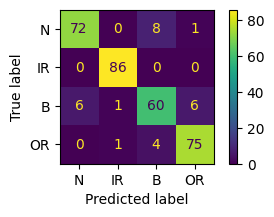

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/GoogleNet_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfgoogleNet = {'Modelname':['GoogleNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### SqeezeNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[tar])
    Model = SqeezeNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning SqeezeNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/SqeezeNet_'+tarData[tar]+'_N.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 50.7MB/s]


Fine tuning SqeezeNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 30.27    Val Accuracy = 37.50
[1/20]   Train Accuracy = 61.13    Val Accuracy = 67.97
[2/20]   Train Accuracy = 74.22    Val Accuracy = 74.22
[3/20]   Train Accuracy = 82.62    Val Accuracy = 80.86
[4/20]   Train Accuracy = 86.43    Val Accuracy = 81.64
[5/20]   Train Accuracy = 88.38    Val Accuracy = 88.28
[6/20]   Train Accuracy = 90.92    Val Accuracy = 84.77
[7/20]   Train Accuracy = 92.38    Val Accuracy = 85.94
[8/20]   Train Accuracy = 91.99    Val Accuracy = 89.06
[9/20]   Train Accuracy = 92.97    Val Accuracy = 88.67
[10/20]   Train Accuracy = 94.82    Val Accuracy = 89.45
[11/20]   Train Accuracy = 95.61    Val Accuracy = 88.28
[12/20]   Train Accuracy = 96.00    Val Accuracy = 90.23
[13/20]   Train Accuracy = 96.68    Val Accuracy = 91.41
[14/20]   Train Accuracy = 98.05    Val Accuracy = 89.84
[15/20]   Train Accuracy = 97.85    Val Accuracy = 89.45
[16/20]   Train 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 23.14    Val Accuracy = 41.02
[1/20]   Train Accuracy = 53.61    Val Accuracy = 66.41
[2/20]   Train Accuracy = 74.71    Val Accuracy = 80.08
[3/20]   Train Accuracy = 82.62    Val Accuracy = 74.61
[4/20]   Train Accuracy = 90.23    Val Accuracy = 85.94
[5/20]   Train Accuracy = 92.38    Val Accuracy = 88.67
[6/20]   Train Accuracy = 92.09    Val Accuracy = 90.23
[7/20]   Train Accuracy = 96.48    Val Accuracy = 90.23
[8/20]   Train Accuracy = 96.78    Val Accuracy = 89.06
[9/20]   Train Accuracy = 97.27    Val Accuracy = 91.02
[10/20]   Train Accuracy = 97.27    Val Accuracy = 92.19
[11/20]   Train Accuracy = 97.95    Val Accuracy = 93.36
[12/20]   Train Accuracy = 98.73    Val Accuracy = 91.41
[13/20]   Train Accuracy = 99.12    Val Accuracy = 90.62
[14/20]   Train Accuracy = 98.83    Val Accuracy = 91.80
[15/20]   Train Accuracy = 98.93    Val Accuracy = 88.67
[16/20]   Train 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 25.78    Val Accuracy = 39.06
[1/20]   Train Accuracy = 54.10    Val Accuracy = 42.19
[2/20]   Train Accuracy = 69.82    Val Accuracy = 71.48
[3/20]   Train Accuracy = 81.45    Val Accuracy = 78.91
[4/20]   Train Accuracy = 87.11    Val Accuracy = 82.42
[5/20]   Train Accuracy = 91.70    Val Accuracy = 85.55
[6/20]   Train Accuracy = 94.43    Val Accuracy = 89.06
[7/20]   Train Accuracy = 95.41    Val Accuracy = 90.62
[8/20]   Train Accuracy = 97.27    Val Accuracy = 88.28
[9/20]   Train Accuracy = 97.07    Val Accuracy = 88.28
[10/20]   Train Accuracy = 97.17    Val Accuracy = 91.41
[11/20]   Train Accuracy = 97.46    Val Accuracy = 89.45
[12/20]   Train Accuracy = 98.83    Val Accuracy = 88.28
[13/20]   Train Accuracy = 98.24    Val Accuracy = 90.62
[14/20]   Train Accuracy = 99.12    Val Accuracy = 91.41
[15/20]   Train Accuracy = 99.61    Val Accuracy = 92.97
[16/20]   Train 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 30.66    Val Accuracy = 52.34
[1/20]   Train Accuracy = 56.05    Val Accuracy = 75.39
[2/20]   Train Accuracy = 76.66    Val Accuracy = 76.95
[3/20]   Train Accuracy = 82.03    Val Accuracy = 83.59
[4/20]   Train Accuracy = 83.50    Val Accuracy = 86.72
[5/20]   Train Accuracy = 86.33    Val Accuracy = 87.89
[6/20]   Train Accuracy = 89.16    Val Accuracy = 88.67
[7/20]   Train Accuracy = 88.28    Val Accuracy = 84.38
[8/20]   Train Accuracy = 90.14    Val Accuracy = 86.72
[9/20]   Train Accuracy = 92.97    Val Accuracy = 84.38
[10/20]   Train Accuracy = 93.16    Val Accuracy = 87.11
[11/20]   Train Accuracy = 94.24    Val Accuracy = 82.81
[12/20]   Train Accuracy = 95.31    Val Accuracy = 89.45
[13/20]   Train Accuracy = 96.09    Val Accuracy = 92.58
[14/20]   Train Accuracy = 97.07    Val Accuracy = 92.19
[15/20]   Train Accuracy = 97.36    Val Accuracy = 89.06
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 25.68    Val Accuracy = 40.62
[1/20]   Train Accuracy = 55.66    Val Accuracy = 53.12
[2/20]   Train Accuracy = 71.88    Val Accuracy = 72.66
[3/20]   Train Accuracy = 84.08    Val Accuracy = 87.89
[4/20]   Train Accuracy = 88.28    Val Accuracy = 91.41
[5/20]   Train Accuracy = 93.85    Val Accuracy = 89.06
[6/20]   Train Accuracy = 95.41    Val Accuracy = 85.55
[7/20]   Train Accuracy = 95.41    Val Accuracy = 93.36
[8/20]   Train Accuracy = 97.07    Val Accuracy = 94.53
[9/20]   Train Accuracy = 97.27    Val Accuracy = 95.70
[10/20]   Train Accuracy = 97.46    Val Accuracy = 94.53
[11/20]   Train Accuracy = 98.54    Val Accuracy = 92.19
[12/20]   Train Accuracy = 98.93    Val Accuracy = 94.92
[13/20]   Train Accuracy = 99.12    Val Accuracy = 96.09
[14/20]   Train Accuracy = 99.41    Val Accuracy = 96.09
[15/20]   Train Accuracy = 99.61    Val Accuracy = 96.09
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 29.30    Val Accuracy = 58.98
[1/20]   Train Accuracy = 65.04    Val Accuracy = 72.27
[2/20]   Train Accuracy = 82.42    Val Accuracy = 75.39
[3/20]   Train Accuracy = 86.52    Val Accuracy = 82.42
[4/20]   Train Accuracy = 90.33    Val Accuracy = 87.11
[5/20]   Train Accuracy = 91.50    Val Accuracy = 86.33
[6/20]   Train Accuracy = 94.92    Val Accuracy = 89.06
[7/20]   Train Accuracy = 96.00    Val Accuracy = 83.98
[8/20]   Train Accuracy = 94.43    Val Accuracy = 89.06
[9/20]   Train Accuracy = 96.29    Val Accuracy = 93.36
[10/20]   Train Accuracy = 97.27    Val Accuracy = 92.19
[11/20]   Train Accuracy = 97.17    Val Accuracy = 88.28
[12/20]   Train Accuracy = 98.05    Val Accuracy = 89.45
[13/20]   Train Accuracy = 98.24    Val Accuracy = 88.67
[14/20]   Train Accuracy = 98.54    Val Accuracy = 91.02
[15/20]   Train Accuracy = 99.12    Val Accuracy = 92.97
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 26.17    Val Accuracy = 48.44
[1/20]   Train Accuracy = 56.93    Val Accuracy = 69.53
[2/20]   Train Accuracy = 73.34    Val Accuracy = 70.70
[3/20]   Train Accuracy = 77.34    Val Accuracy = 80.86
[4/20]   Train Accuracy = 84.18    Val Accuracy = 75.39
[5/20]   Train Accuracy = 86.82    Val Accuracy = 80.86
[6/20]   Train Accuracy = 89.36    Val Accuracy = 86.72
[7/20]   Train Accuracy = 90.23    Val Accuracy = 83.98
[8/20]   Train Accuracy = 90.53    Val Accuracy = 86.33
[9/20]   Train Accuracy = 92.38    Val Accuracy = 85.55
[10/20]   Train Accuracy = 94.63    Val Accuracy = 85.55
[11/20]   Train Accuracy = 94.92    Val Accuracy = 86.33
[12/20]   Train Accuracy = 97.07    Val Accuracy = 91.41
[13/20]   Train Accuracy = 95.80    Val Accuracy = 88.28
[14/20]   Train Accuracy = 98.14    Val Accuracy = 89.84
[15/20]   Train Accuracy = 98.14    Val Accuracy = 87.11
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 29.88    Val Accuracy = 40.62
[1/20]   Train Accuracy = 55.27    Val Accuracy = 53.91
[2/20]   Train Accuracy = 71.00    Val Accuracy = 71.88
[3/20]   Train Accuracy = 75.00    Val Accuracy = 80.47
[4/20]   Train Accuracy = 80.96    Val Accuracy = 82.03
[5/20]   Train Accuracy = 83.11    Val Accuracy = 76.95
[6/20]   Train Accuracy = 85.16    Val Accuracy = 80.86
[7/20]   Train Accuracy = 87.89    Val Accuracy = 78.12
[8/20]   Train Accuracy = 87.89    Val Accuracy = 85.16
[9/20]   Train Accuracy = 88.87    Val Accuracy = 80.08
[10/20]   Train Accuracy = 90.43    Val Accuracy = 83.98
[11/20]   Train Accuracy = 92.87    Val Accuracy = 84.77
[12/20]   Train Accuracy = 94.04    Val Accuracy = 82.42
[13/20]   Train Accuracy = 93.46    Val Accuracy = 78.52
[14/20]   Train Accuracy = 93.95    Val Accuracy = 73.44
[15/20]   Train Accuracy = 94.82    Val Accuracy = 81.25
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 28.03    Val Accuracy = 47.66
[1/20]   Train Accuracy = 52.34    Val Accuracy = 54.30
[2/20]   Train Accuracy = 64.45    Val Accuracy = 64.84
[3/20]   Train Accuracy = 71.00    Val Accuracy = 66.02
[4/20]   Train Accuracy = 71.68    Val Accuracy = 55.47
[5/20]   Train Accuracy = 74.71    Val Accuracy = 62.89
[6/20]   Train Accuracy = 77.54    Val Accuracy = 73.83
[7/20]   Train Accuracy = 78.32    Val Accuracy = 62.89
[8/20]   Train Accuracy = 81.84    Val Accuracy = 74.22
[9/20]   Train Accuracy = 82.71    Val Accuracy = 67.97
[10/20]   Train Accuracy = 84.28    Val Accuracy = 72.66
[11/20]   Train Accuracy = 84.38    Val Accuracy = 77.34
[12/20]   Train Accuracy = 86.43    Val Accuracy = 70.70
[13/20]   Train Accuracy = 86.33    Val Accuracy = 78.12
[14/20]   Train Accuracy = 89.75    Val Accuracy = 77.34
[15/20]   Train Accuracy = 91.31    Val Accuracy = 79.30
[16/20]   Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 29.54    Val Accuracy = 35.74
[1/20]   Train Accuracy = 47.71    Val Accuracy = 50.39
[2/20]   Train Accuracy = 53.37    Val Accuracy = 50.98
[3/20]   Train Accuracy = 57.13    Val Accuracy = 51.76
[4/20]   Train Accuracy = 60.84    Val Accuracy = 53.32
[5/20]   Train Accuracy = 62.35    Val Accuracy = 57.23
[6/20]   Train Accuracy = 63.77    Val Accuracy = 55.47
[7/20]   Train Accuracy = 65.14    Val Accuracy = 53.32
[8/20]   Train Accuracy = 66.36    Val Accuracy = 55.08
[9/20]   Train Accuracy = 68.21    Val Accuracy = 56.45
[10/20]   Train Accuracy = 70.46    Val Accuracy = 55.86
[11/20]   Train Accuracy = 71.63    Val Accuracy = 52.15
[12/20]   Train Accuracy = 73.05    Val Accuracy = 54.30
[13/20]   Train Accuracy = 73.44    Val Accuracy = 57.23
[14/20]   Train Accuracy = 76.07    Val Accuracy = 53.12
[15/20]   Train Accuracy = 76.90    Val Accuracy = 55.08
[16/20]   Train Acc

Validation Accuracy =  93.75
__________________________________________________
Pricision Score = 0.9396670474278681
__________________________________________________
F_1 Score =  0.9343232423084444
__________________________________________________
Recall Score =  0.9335613980232755
__________________________________________________
Response time per batch 0.003752470016479492


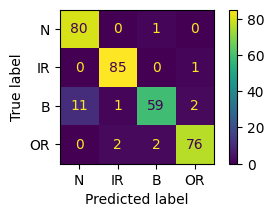

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loadNoisydata(root_path, tarData[0])
Model = torch.load('./saved_models/SqeezeNet_'+tarData[0]+'_N.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch, _, _ = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}